1、Generate dataset with (10000, 2) data points

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll 
import torch

shape of swiss roll: (10000, 2)


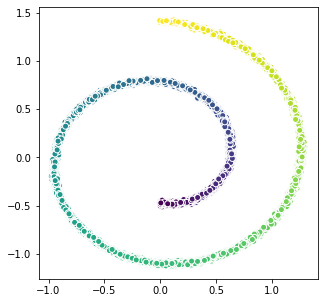

In [2]:
s_roll,s_color = make_swiss_roll(10**4,noise=0.1) # 10000 data points
s_roll = s_roll[:,[0,2]]/10.0

print("shape of swiss roll:",np.shape(s_roll))

data = s_roll.T

fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(*data,edgecolor='white',c = s_color);


dataset = torch.Tensor(s_roll).float()

2、value of parameter

betas: $\beta$

alphas: $\alpha = 1-\beta$

alphas_prod: $\overline{\alpha_t} = \prod_{s=1}^{t}\alpha_s$

alphas_prod_p: $1 + alphas\_prod[:-1] = \overline{\alpha_{t-1}}$

alphas_bar_sqrt: $\sqrt{\overline{\alpha_t}}$

one_minus_alphas_bar_log: $log(1-\overline{\alpha_t})$

one_minus_alphas_bar_sqrt: $\sqrt{1-\overline{\alpha_t}}$

In [3]:
num_steps = 100


betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape 
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


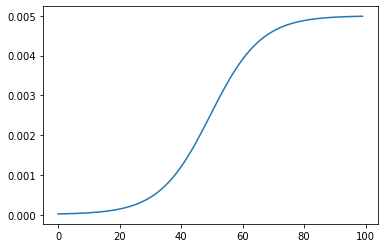

In [4]:
plt.plot(betas)

3、Forward Process

$x_t = \sqrt{\overline{\alpha_t}}x_0+\sqrt{1-\overline{\alpha_t}}\epsilon$

In [5]:
def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)

4、Display diffusing results at each step

CPU times: user 1.82 s, sys: 30.9 ms, total: 1.85 s
Wall time: 1.84 s


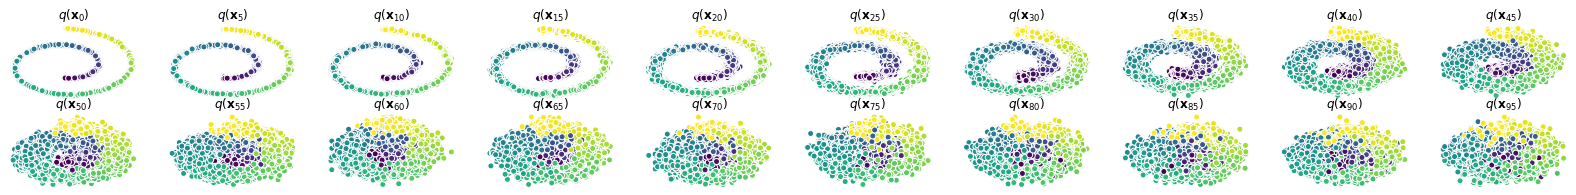

In [6]:
%%time
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))
    axs[j,k].scatter(q_i[:,0],q_i[:,1],c=s_color,edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

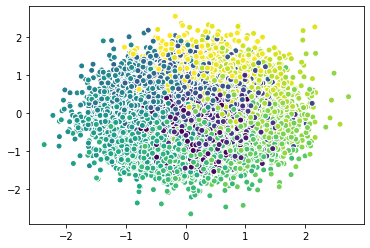

In [7]:
q_i = q_x(dataset,torch.tensor([num_steps-1]))
plt.scatter(q_i[:,0],q_i[:,1],c=s_color,edgecolor='white')

5、Gaussian model

In [8]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t):
        #  x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x
# nn.Embedding：https://blog.csdn.net/qq_39540454/article/details/115215056
# model = MLPDiffusion(num_steps)
# output = model(x,step)

6、compute diffusion loss

model = MLPDiffusion(num_steps)

x_0: batch_x

alphas_bar_sqrt：$\sqrt{\overline{\alpha_t}}$

one_minus_alphas_bar_sqrt：$\sqrt{1-\overline{\alpha_t}}$

n_steps: num_steps = 100

loss = diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps)

In [9]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    

    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    

    a = alphas_bar_sqrt[t] # torch.Size([batchsize, 1])
    

    aml = one_minus_alphas_bar_sqrt[t] # torch.Size([batchsize, 1])
    

    e = torch.randn_like(x_0) # torch.Size([batchsize, 2])
    

    x = x_0*a+e*aml # torch.Size([batchsize, 2])
    

    output = model(x,t.squeeze(-1)) #t.squeeze(-1)为torch.Size([batchsize])
    # output:torch.Size([batchsize, 2])

    return (e - output).square().mean()

7、inference

In [10]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
#     cur_x = torch.randn(shape)
    cur_x = q_i
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

$
\begin{aligned}
\tilde{\boldsymbol{\mu}}_{t} &=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \mathbf{z}_{t}\right)
\end{aligned}
$


In [11]:
def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x,t)

    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))

#     z = torch.randn_like(x)
#     sigma_t = betas[t].sqrt()

    sample = mean# + sigma_t * z

    return (sample)

8、Train model

Training model...
tensor(0.7966, grad_fn=<MeanBackward0>)
tensor(0.8059, grad_fn=<MeanBackward0>)
tensor(0.9196, grad_fn=<MeanBackward0>)
tensor(0.6911, grad_fn=<MeanBackward0>)
tensor(0.7317, grad_fn=<MeanBackward0>)
tensor(0.6962, grad_fn=<MeanBackward0>)
tensor(0.5896, grad_fn=<MeanBackward0>)
tensor(0.5815, grad_fn=<MeanBackward0>)
tensor(0.5461, grad_fn=<MeanBackward0>)
tensor(0.7372, grad_fn=<MeanBackward0>)
CPU times: user 10h 16min 16s, sys: 5min 1s, total: 10h 21min 18s
Wall time: 1h 17min 54s


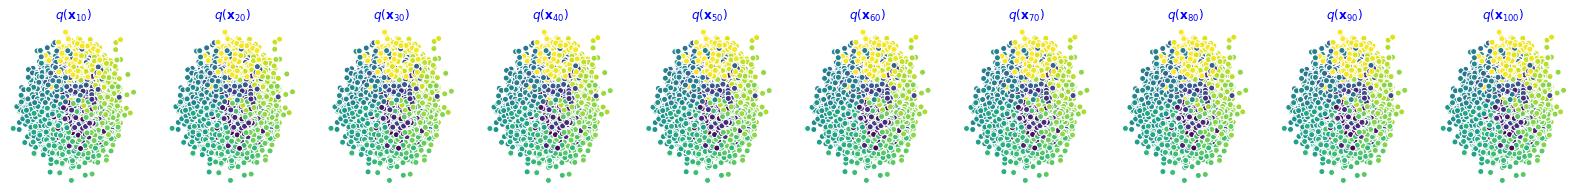

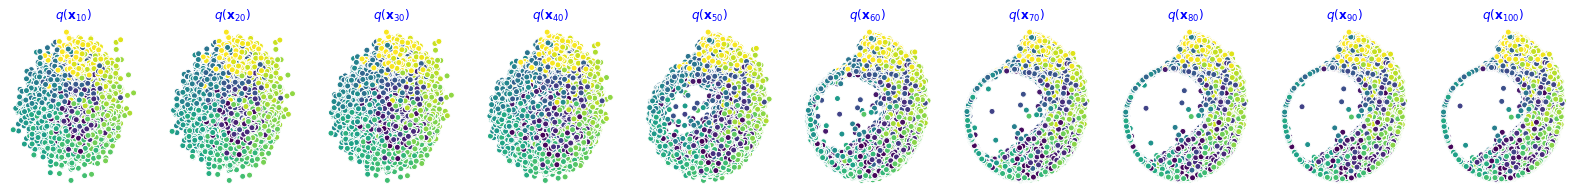

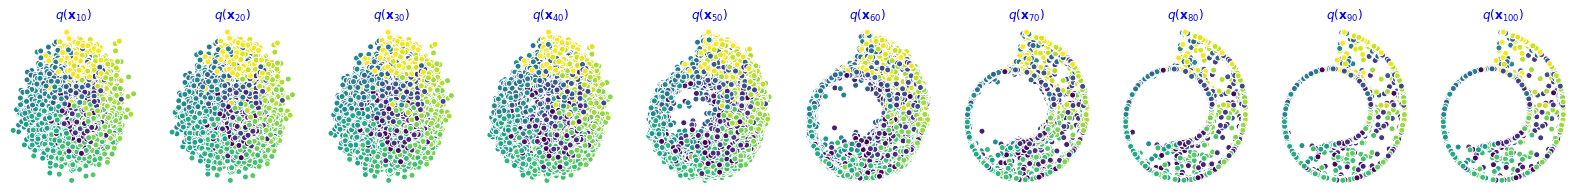

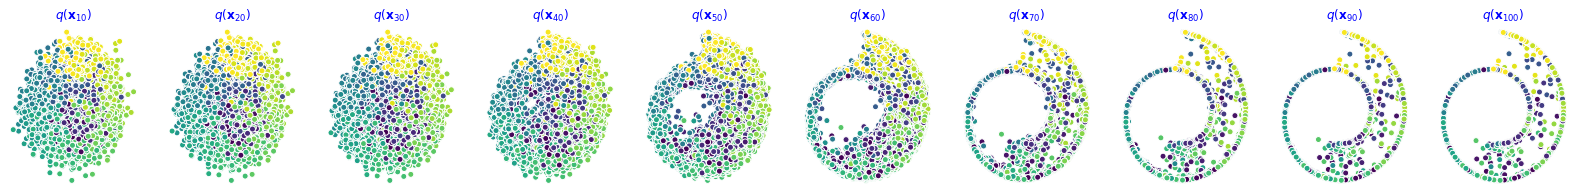

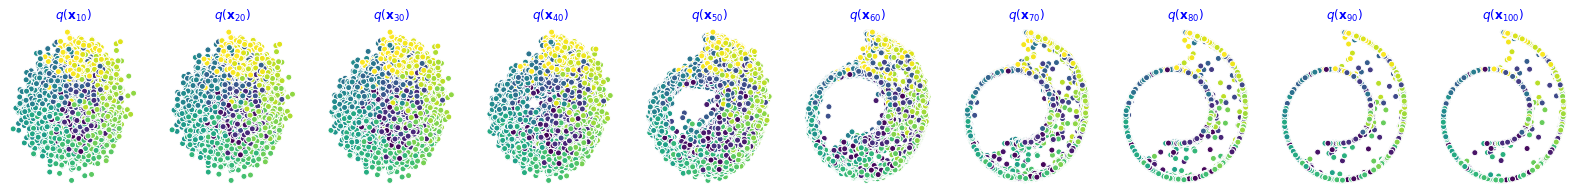

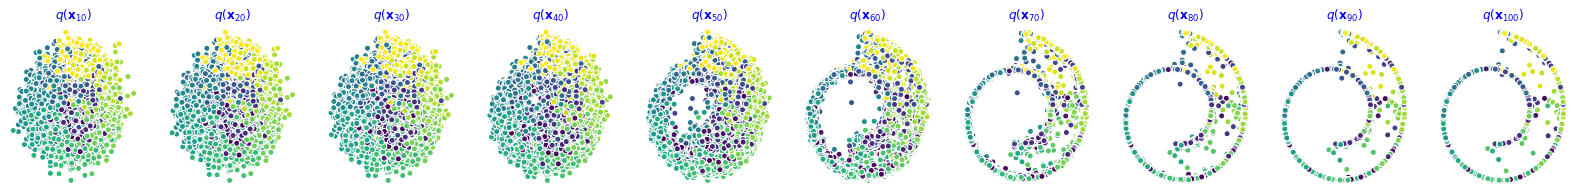

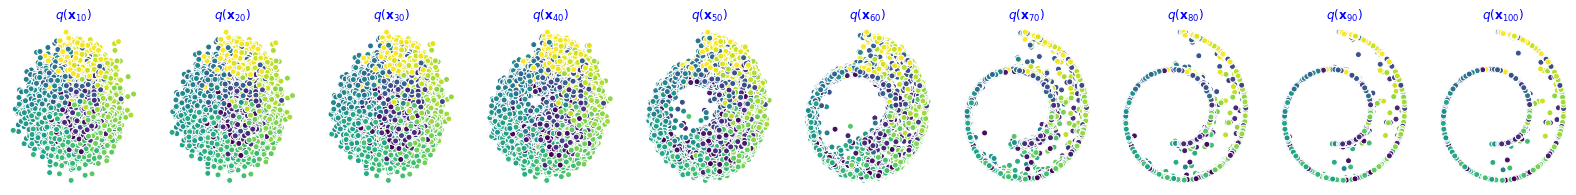

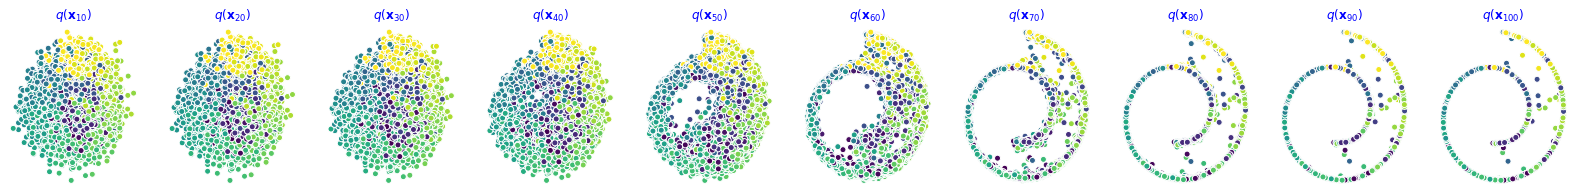

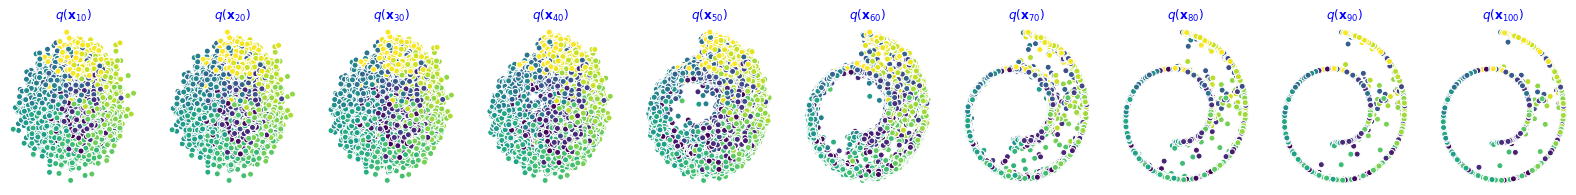

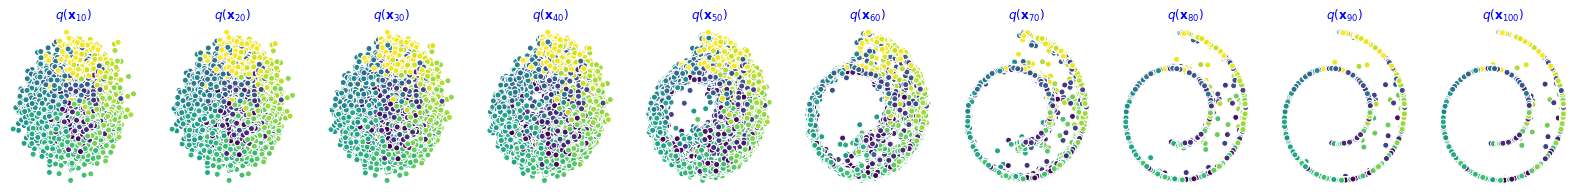

In [12]:
%%time
    
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 1000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],c=s_color,edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

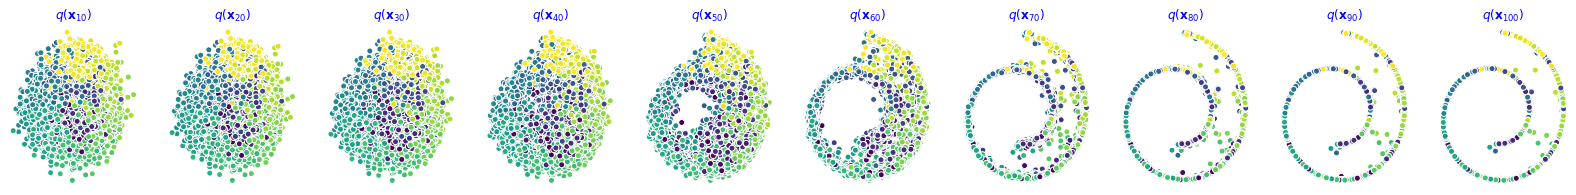

In [13]:
x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
fig,axs = plt.subplots(1,10,figsize=(28,3))
for i in range(1,11):
    cur_x = x_seq[i*10].detach()
    axs[i-1].scatter(cur_x[:,0],cur_x[:,1],c=s_color,edgecolor='white');
    axs[i-1].set_axis_off();
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

Text(0.5, 1.0, '$q(\\mathbf{x}_{100})$')

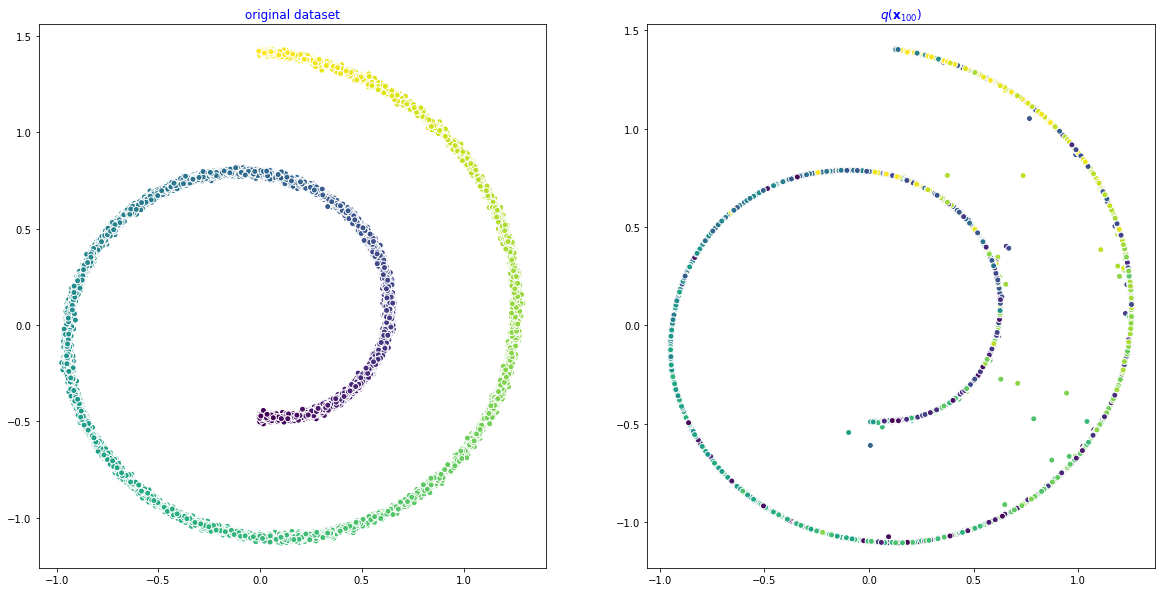

In [14]:
fig,ax = plt.subplots(1,2,figsize = (20,10))
ax[0].scatter(*data,edgecolor='white',c = s_color)
ax[0].set_title('original dataset')

cur_x = x_seq[100].detach()
ax[1].scatter(cur_x[:,0],cur_x[:,1],c=s_color,edgecolor='white');
ax[1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')